In [1]:
! python3 -c 'import tensorflow as tf; print(tf.__version__)'  # for Python 3


2021-03-19 13:46:37.309775: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-03-19 13:46:37.309835: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2.4.1


# Sequence-to-Sequence Prediction Problems
Sequence prediction often involves forecasting the next value in a real valued sequence or outputting a class label for an input sequence.

This is often framed as a sequence of one input time step to one output time step (e.g. one-to-one) or multiple input time steps to one output time step (many-to-one) type sequence prediction problem.

One approach to seq2seq prediction problems that has proven very effective is called the Encoder-Decoder LSTM.

## Encoder-Decoder LSTM 
The LSTM network can be organized into an architecture called the Encoder-Decoder LSTM that allows the model to be used to both support variable length input sequences and to predict or output variable length output sequences.

In this architecture, an encoder LSTM model reads the input sequence step-by-step. After reading in the entire input sequence, the hidden state or output of this model represents an internal learned representation of the entire input sequence as a fixed-length vector. This vector is then provided as an input to the decoder model that interprets it as each step in the output sequence is generated
This architecture is comprised of two models: one for reading the input sequence and encoding it into a fixed-length vector, and a second for decoding the fixed-length vector and outputting the predicted sequence. The use of the models in concert gives the architecture its name of Encoder-Decoder LSTM designed specifically for seq2seq problems.
The innovation of this architecture is the use of a fixed-sized internal representation in the heart of the model that input sequences are read to and output sequences are read from. For this reason, the method may be referred to as sequence embedding.

    … RNN Encoder-Decoder, consists of two recurrent neural networks (RNN) that act as an encoder and a decoder pair. The encoder maps a variable-length source sequence to a fixed-length vector, and the decoder maps the vector representation back to a variable-length target sequence.

    — Learning Phrase Representations using RNN Encoder-Decoder for Statistical Machine Translation, 2014.

The Encoder-Decoder LSTM was developed for natural language processing problems where it demonstrated state-of-the-art performance, specifically in the area of text translation called statistical machine translation. 

    The proposed RNN Encoder-Decoder naturally generates a continuous-space representation of a phrase. […] From the visualization, it is clear that the RNN Encoder-Decoder captures both semantic and syntactic structures of the phrases

    — Learning Phrase Representations using RNN Encoder-Decoder for Statistical Machine Translation, 2014.

## Keras implementation

For a given dataset of sequences, an encoder-decoder LSTM is configured to read the input sequence, encode it, decode it, and recreate it. The performance of the model is evaluated based on the model’s ability to recreate the input sequence.

Once the model achieves a desired level of performance recreating the sequence, the decoder part of the model may be removed, leaving just the encoder model. This model can then be used to encode input sequences to a fixed-length vector.

The resulting vectors can then be used in a variety of applications, not least as a compressed representation of the sequence as an input to another supervised learning model.

We can think of the model as being comprised of two key parts: the encoder and the decoder.

One or more LSTM layers can be used to implement the encoder model. The output of this model is a fixed-size vector that represents the internal representation of the input sequence. The number of memory cells in this layer defines the length of this fixed-sized vector.

### Anomaly detection

How will you detect anomalies using an autoencoder? Recall that an autoencoder is trained to minimize reconstruction error. You will train an autoencoder on the normal rhythms only, then use it to reconstruct all the data. Our hypothesis is that the abnormal rhythms will have higher reconstruction error. You will then classify a rhythm as an anomaly if the reconstruction error surpasses a fixed threshold.

In [2]:
import numpy as np
import pandas as pd
from os import listdir
from pathlib import Path
from os.path import isfile, join

import tensorflow as tf
from tensorflow import keras
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
plt.rcParams.update({
    'font.size': 7, 
    'lines.markersize': 0.9,
    'legend.markerscale': 5, 
    'lines.linewidth':0.7, 
    'lines.linestyle':'--',
    'axes.titlesize':'large',  
    'axes.labelsize':'large' 
})
def add_matplotlib_params(ax):
    plt.xticks(fontsize=13) #per impostare la dimensione dei caratteri delle etichette di spunta
    plt.yticks(fontsize=13) #per impostare la dimensione dei caratteri delle etichette di spunta
    plt.setp(ax.get_xticklabels(), fontsize=13)# per impostare la dimensione dei caratteri delle etichette di segno di spunta
    ax.tick_params(axis='both', labelsize=13) #per impostare Tick Labels Font Size




Bad key "text.kerning_factor" on line 4 in
/data01/home/baroncelli/.conda/envs/bphd/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


## Directories

In [3]:
datapath = Path("/data01/home/baroncelli/phd/repos/phd/rtapipe/analysis/notebook_dataset_generation_for_models_output")
datapath

PosixPath('/data01/home/baroncelli/phd/repos/phd/rtapipe/analysis/notebook_dataset_generation_for_models_output')

In [4]:
currentdir = Path().absolute()
currentdir

PosixPath('/data01/home/baroncelli/phd/repos/phd/rtapipe/analysis')

In [5]:
outdir = currentdir.joinpath("notebook_dataset_generation_for_models_output")
outdir

PosixPath('/data01/home/baroncelli/phd/repos/phd/rtapipe/analysis/notebook_dataset_generation_for_models_output')

In [6]:
def processDataDir(dataDir, sampleClass, sampleSize, windowSize, deleteRows=0):
    dataframes = [  pd.read_csv(join(dataDir, f), header=0) for f in listdir(dataDir) if isfile(join(dataDir, f))]
    dataframe = pd.concat(dataframes, axis=0)

    if deleteRows > 0:
        dataframe = dataframe[:-deleteRows]
    
    numberOfSamples = int(dataframe.shape[0]/sampleSize)
    bkgTimespan = round( (dataframe.shape[0]*windowSize)/60/60, 2)
    
    print(f"Found {len(dataframes)} files! Each file has: \n\t{dataframes[0].shape[0]} rows (samples) \n\t{dataframes[0].shape[1]} columns!")

    print(f"Temporal size = {bkgTimespan} h. Each sample is equivalent to {bkgTimespan/numberOfSamples*60*60} seconds")

    
    ## USE A WINDOW GENERATOR HERE?
    
    dataframe.head()
    dataframe = pd.DataFrame(dataframe["COUNTS"].values.reshape(numberOfSamples, sampleSize))
    dataframe[sampleSize] = sampleClass
    print(dataframe.shape)
    print(dataframe.head(2))
        
        
        
    return dataframe

In [7]:
SAMPLE_SIZE = 180
WINDOW_SIZE = 10

In [8]:
bkgDataDir = datapath.joinpath("run0406_ID000126_OK_bkg_only","csv")
bkgSamples = processDataDir(bkgDataDir, 0, SAMPLE_SIZE, WINDOW_SIZE)

Found 100 files! Each file has: 
	180 rows (samples) 
	5 columns!
Temporal size = 50.0 h. Each sample is equivalent to 1800.0 seconds
(100, 181)
   0    1    2    3    4    5    6    7    8    9    ...  171  172  173  174  \
0  293  235  279  224  277  256  272  252  245  260  ...  253  252  279  252   
1  251  267  273  288  282  212  283  301  233  255  ...  262  244  267  268   

   175  176  177  178  179  180  
0  249  244  274  248  239    0  
1  251  251  269  270  250    0  

[2 rows x 181 columns]


In [9]:
bkgSrcDataDir = datapath.joinpath("run0406_ID000126_OK_bkg_src","csv")
bkgSrcSamples = processDataDir(bkgSrcDataDir, 1, SAMPLE_SIZE, WINDOW_SIZE)

Found 100 files! Each file has: 
	180 rows (samples) 
	5 columns!
Temporal size = 50.0 h. Each sample is equivalent to 1800.0 seconds
(100, 181)
   0    1    2    3    4    5    6    7    8    9    ...  171  172  173  174  \
0  243  251  286  257  274  249  284  296  275  267  ...  286  244  256  285   
1  273  237  280  262  255  267  236  258  286  268  ...  258  282  250  265   

   175  176  177  178  179  180  
0  300  285  274  269  262    1  
1  246  272  274  284  275    1  

[2 rows x 181 columns]


In [10]:
#bkgSamples["COUNTS"][:140].plot()
#bkgSrcSamples["COUNTS"][:140].plot()

## Bkg + BkgSrc

In [11]:
counts = pd.concat((bkgSamples,bkgSrcSamples), axis=0).reset_index(drop=True)
counts

,0,1,2,3,4,5,6,7,8,9,...,171,172,173,174,175,176,177,178,179,180
0,293,235,279,224,277,256,272,252,245,260,...,253,252,279,252,249,244,274,248,239,0
1,251,267,273,288,282,212,283,301,233,255,...,262,244,267,268,251,251,269,270,250,0
2,268,280,274,231,270,273,271,261,250,248,...,243,268,230,278,276,245,255,269,240,0
3,289,273,237,234,271,280,249,268,257,269,...,251,245,277,263,222,291,273,258,287,0
4,270,273,236,227,258,271,246,245,239,284,...,253,252,272,241,263,289,266,279,255,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,247,236,269,280,281,251,276,235,285,268,...,305,284,264,270,250,271,281,260,269,1
196,249,277,226,271,267,241,267,258,258,280,...,254,276,256,248,277,271,278,251,272,1
197,277,293,275,272,275,256,235,267,243,254,...,275,269,258,250,283,261,253,241,270,1
198,267,250,284,270,245,241,254,248,229,285,...,262,262,246,251,255,246,274,283,269,1


### Let's plot some samples

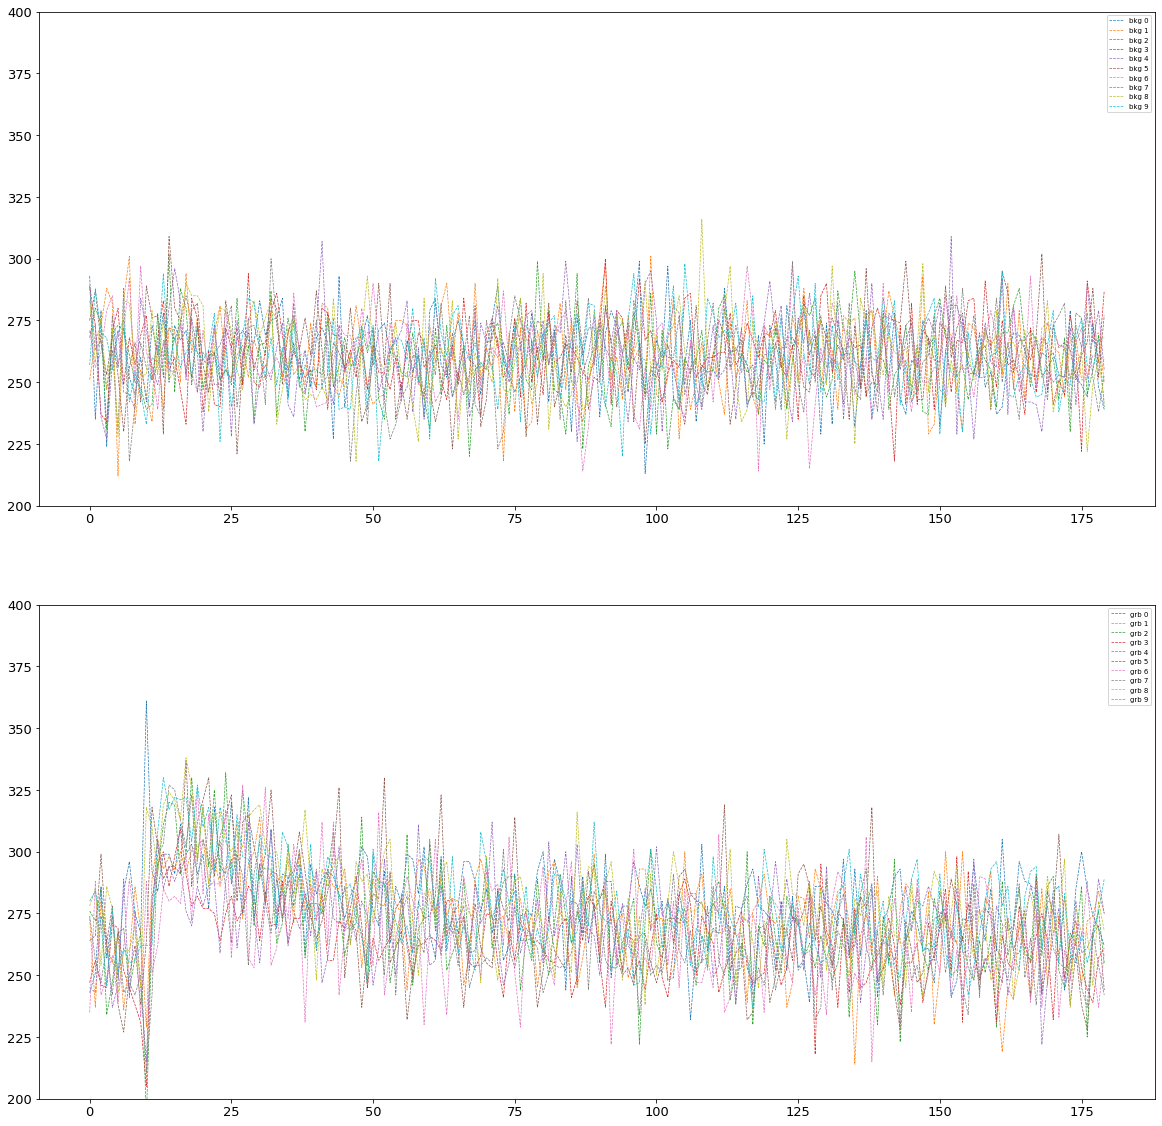

In [12]:
fig, ax = plt.subplots(2,1,figsize=(20,20))
add_matplotlib_params(ax[0])
ax[0].set_ylim(200, 400)
ax[1].set_ylim(200, 400)

samples = 10
for j in range(samples):
    ax[0].plot(bkgSamples.iloc[j,:-1], label=f"bkg {str(j)}")
        
for j in range(samples):
    ax[1].plot(bkgSrcSamples.iloc[j,:-1], label=f"grb {str(j)}")
ax[0].legend()
ax[1].legend()



### Train/Test split

In [13]:
column_indices = {name: i for i, name in enumerate(counts.columns)}

n = len(counts)
train_df = counts[0:int(n*0.7)]
val_counts = counts[int(n*0.7):int(n*0.9)]
test_counts = counts[int(n*0.9):]

num_features = counts.shape[1]
num_features

181

In [14]:
# The last element contains the labels
labels = counts.values[:, -1]
# The other data points are the electrocadriogram data
data = counts.values[:, 0:-1]

In [15]:
train_data, other_data, train_labels, other_labels = train_test_split(
    data, labels, test_size=0.4, random_state=69
)

test_data, val_data, test_labels, val_labels = train_test_split(
    other_data, other_labels, test_size=0.1, random_state=69
)

# print(f"train_data: {train_data.shape}, test_data: {test_data.shape}")

# let's remove last one
train_data = train_data[:-1, :]
test_data = test_data[:-1, :]
val_data = val_data[:-1, :]
train_labels = train_labels[:-1]
test_labels = test_labels[:-1]
val_labels = val_labels[:-1]


print(f"train_data: {train_data.shape}, train_labels: {train_labels}")
print(f"test_data: {test_data.shape}, test_labels: {test_labels}")
print(f"val_data: {val_data.shape}, val_labels: {val_labels}")



train_data: (119, 180), train_labels: [0 1 1 0 0 1 0 0 0 0 0 1 1 1 0 0 0 0 1 0 0 1 1 1 1 1 0 0 1 1 1 0 1 0 1 0 1
 1 0 0 0 1 1 1 0 0 0 1 0 1 0 1 1 1 0 0 1 1 0 1 1 1 0 0 1 0 0 1 1 1 1 0 1 0
 1 0 1 1 0 0 1 0 0 1 1 0 0 1 1 0 1 0 1 1 1 1 1 0 0 0 1 0 0 0 0 1 1 1 0 0 0
 1 0 0 0 1 1 0 1]
test_data: (71, 180), test_labels: [0 0 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 1 0 1 1 1 1 0 0 1 1 1 0 0 1 1 0
 0 1 1 1 0 0 1 1 0 0 0 1 1 0 1 1 1 0 1 1 0 0 0 1 1 0 0 0 1 0 0 1 1 1]
val_data: (7, 180), val_labels: [1 0 1 0 0 0 0]


In [16]:
train_data

array([[235, 226, 262, ..., 248, 278, 273],
       [267, 250, 284, ..., 274, 283, 269],
       [252, 232, 247, ..., 272, 260, 262],
       ...,
       [260, 268, 263, ..., 268, 262, 282],
       [235, 248, 292, ..., 263, 263, 272],
       [274, 256, 247, ..., 267, 254, 242]])

### Normalize the data to `[0,1]`.


In [17]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

In [18]:
print(train_labels.shape)
print(train_data.shape)

(119,)
(119, 180)


In [19]:
print(test_labels.shape)
print(test_data.shape)

(71,)
(71, 180)


In [20]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

anomalous_train_data = train_data[train_labels]
anomalous_test_data = test_data[test_labels]
print("anomalous_train_data:", len(anomalous_train_data))

normal_train_data = train_data[~train_labels]
normal_test_data = test_data[~test_labels]
print("normal_train_data:", len(normal_train_data))


anomalous_train_data: 60
normal_train_data: 59


### Plot some samples again

No handles with labels found to put in legend.


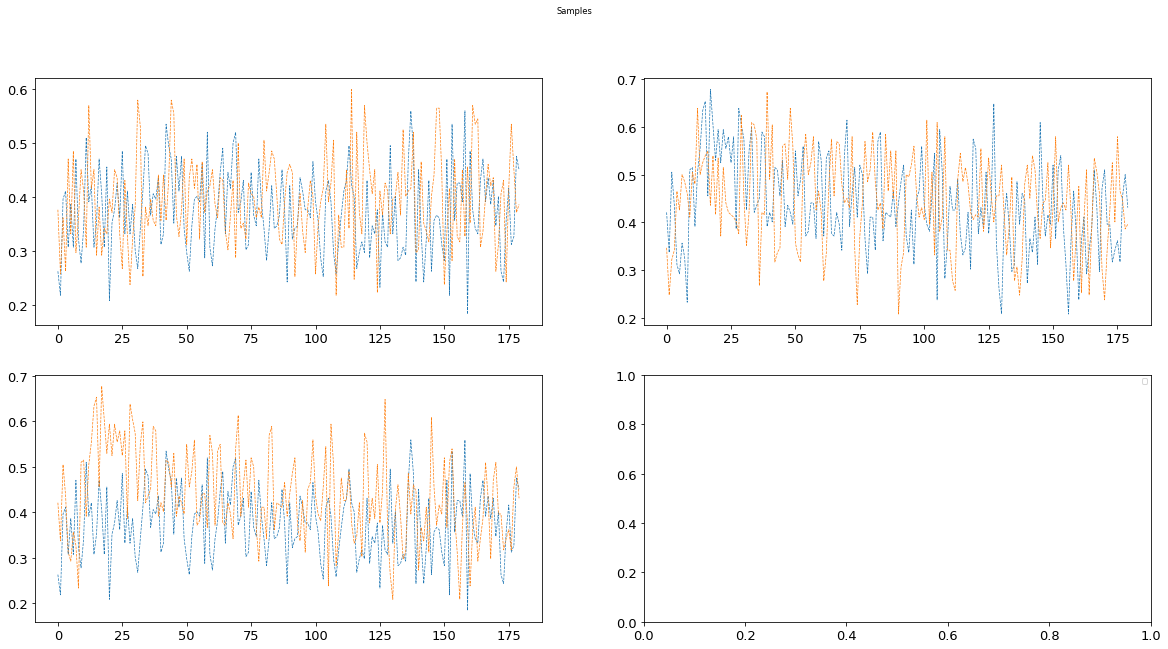

In [21]:
fig, ax = plt.subplots(2,2,figsize=(20,10))
for i in range(2):
  ax[0][0].plot(np.arange(SAMPLE_SIZE), normal_train_data[i])

for i in range(2):
  ax[0][1].plot(np.arange(SAMPLE_SIZE), anomalous_train_data[i])


ax[1][0].plot(np.arange(SAMPLE_SIZE), normal_train_data[0])
ax[1][0].plot(np.arange(SAMPLE_SIZE), anomalous_train_data[0])

fig.suptitle("Samples")
plt.legend()
add_matplotlib_params(ax[0][1])
add_matplotlib_params(ax[1][0])
add_matplotlib_params(ax[1][1])
add_matplotlib_params(ax[0][0])

plt.show()

### The autoencoder model

The decoder output layer must have an number of neuron equals to SAMPLE_SIZE

In [22]:
class AnomalyDetector(models.Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])
    
    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(SAMPLE_SIZE, activation="sigmoid")])
  
  def _plot(self, model, modelName):
    tf.keras.utils.plot_model(
        model,
        to_file=f"{modelName}.png",
        show_shapes=True,
        show_dtype=True,
        show_layer_names=True,
        expand_nested=True,
        dpi=96,
    )    

  def plot(self):
    self._plot(self.encoder, "encoder")
    self._plot(self.decoder, "decoder")

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [23]:
autoencoder.compile(optimizer='adam', loss='mae')

### train and validation tests


In [24]:
print("all background samples: ", normal_train_data.shape) # all background samples
print("a mixture of bgk and grb: ", test_data.shape, "\n", test_labels) # a mixture of bgk and grb

all background samples:  (59, 180)
a mixture of bgk and grb:  (71, 180) 
 [False False  True  True False False False False False False  True  True
  True  True  True  True  True False False False False  True False  True
  True  True  True False False  True  True  True False False  True  True
 False False  True  True  True False False  True  True False False False
  True  True False  True  True  True False  True  True False False False
  True  True False False False  True False False  True  True  True]


### Fit the model

In [25]:
normal_train_data

<tf.Tensor: shape=(59, 180), dtype=float32, numpy=
array([[0.26237625, 0.21782178, 0.3960396 , ..., 0.32673267, 0.47524753,
        0.45049506],
       [0.37623763, 0.25742576, 0.36138615, ..., 0.45049506, 0.37128714,
        0.38613862],
       [0.4009901 , 0.3069307 , 0.5940594 , ..., 0.47029704, 0.32178217,
        0.35643566],
       ...,
       [0.43564355, 0.45049506, 0.37128714, ..., 0.48514852, 0.5148515 ,
        0.32178217],
       [0.42079207, 0.42574257, 0.34653464, ..., 0.34653464, 0.42574257,
        0.3910891 ],
       [0.26237625, 0.32673267, 0.5445545 , ..., 0.4009901 , 0.4009901 ,
        0.44554454]], dtype=float32)>

In [26]:
test_data

<tf.Tensor: shape=(71, 180), dtype=float32, numpy=
array([[0.26732674, 0.35643566, 0.4009901 , ..., 0.35148516, 0.42574257,
        0.43069306],
       [0.36138615, 0.35643566, 0.33168316, ..., 0.38613862, 0.42574257,
        0.43564355],
       [0.37128714, 0.31683168, 0.23762377, ..., 0.45049506, 0.44059405,
        0.28712872],
       ...,
       [0.34653464, 0.48019803, 0.4009901 , ..., 0.44554454, 0.37623763,
        0.5346535 ],
       [0.35643566, 0.28712872, 0.4950495 , ..., 0.32673267, 0.45544556,
        0.44554454],
       [0.37128714, 0.5247525 , 0.33168316, ..., 0.5049505 , 0.44554454,
        0.57425743]], dtype=float32)>

In [27]:
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=10, 
          batch_size=10,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/10
6/6 [==============================] - 1s 84ms/step - loss: 0.1152 - val_loss: 0.0988
Epoch 2/10
6/6 [==============================] - 0s 8ms/step - loss: 0.1050 - val_loss: 0.0962
Epoch 3/10
6/6 [==============================] - 0s 8ms/step - loss: 0.0940 - val_loss: 0.0916
Epoch 4/10
6/6 [==============================] - 0s 8ms/step - loss: 0.0848 - val_loss: 0.0861
Epoch 5/10
6/6 [==============================] - 0s 12ms/step - loss: 0.0765 - val_loss: 0.0841
Epoch 6/10
6/6 [==============================] - 0s 10ms/step - loss: 0.0710 - val_loss: 0.0817
Epoch 7/10
6/6 [==============================] - 0s 9ms/step - loss: 0.0670 - val_loss: 0.0810
Epoch 8/10
6/6 [==============================] - 0s 10ms/step - loss: 0.0655 - val_loss: 0.0815
Epoch 9/10
6/6 [==============================] - 0s 11ms/step - loss: 0.0643 - val_loss: 0.0802
Epoch 10/10
6/6 [==============================] - 0s 12ms/step - loss: 0.0637 - val_loss: 0.0816


### Plot training and validation losses

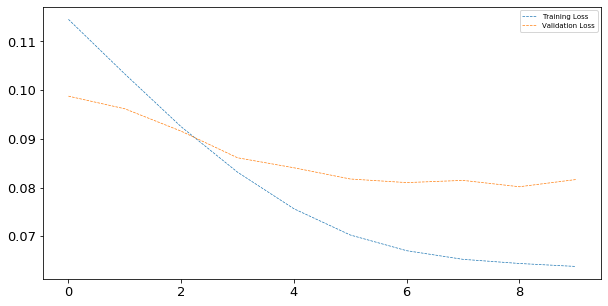

In [28]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.plot(history.history["loss"], label="Training Loss")
ax.plot(history.history["val_loss"], label="Validation Loss")
add_matplotlib_params(ax)
plt.legend()

Let's test our autoencoder: 
* on a normal/background sample
* on a anomalous/source sample


In [29]:
def configureAxis(ax, title):
    ax.set_ylim(0,1)
    ax.set_title(title)
    ax.legend(labels=["Input", "Reconstruction", "Error"], prop={'size': 12})
    ax.set_xlabel("timestep i", fontsize=14)

In [30]:
def plotReconstructionError(sidx, normal_test_data, anomalous_test_data, normal_decoded_imgs, anomalous_decoded_imgs, test_labels):
    fig,ax = plt.subplots(1,2, figsize=(12,5))
    ax[0].plot(normal_test_data[sidx], label=labels[sidx])
    ax[0].plot(normal_decoded_imgs[sidx],'r')  
    ax[0].fill_between(np.arange(SAMPLE_SIZE), normal_decoded_imgs[sidx], normal_test_data[sidx], color='lightcoral', alpha=0.1 )
    configureAxis(ax[0],"Background sample reconstruction")

    ax[1].plot(anomalous_test_data[sidx], label=labels[sidx])
    ax[1].plot(anomalous_decoded_imgs[sidx],'r')  
    ax[1].fill_between(np.arange(SAMPLE_SIZE), anomalous_decoded_imgs[sidx], anomalous_test_data[sidx], color='lightcoral', alpha=0.1 )
    configureAxis(ax[1],"Source sample reconstruction")

    add_matplotlib_params(ax[0])
    add_matplotlib_params(ax[1])

    fig.suptitle="Reconstruction error"
    plt.show()

In [31]:
def recoError(autoencoder):
  normal_encoded_imgs = autoencoder.encoder(normal_test_data).numpy()
  normal_decoded_imgs = autoencoder.decoder(normal_encoded_imgs).numpy()
  anomalous_encoded_imgs = autoencoder.encoder(anomalous_test_data).numpy()
  anomalous_decoded_imgs = autoencoder.decoder(anomalous_encoded_imgs).numpy()

  print(normal_encoded_imgs.shape)
  print(normal_decoded_imgs.shape)
  print(anomalous_encoded_imgs.shape)
  print(anomalous_decoded_imgs.shape)
  #print(anomalous_decoded_imgs[0])

  for i in range(4):
    plotReconstructionError(i, normal_test_data, anomalous_test_data, normal_decoded_imgs, anomalous_decoded_imgs, test_labels)


(34, 8)
(34, 180)
(37, 8)
(37, 180)


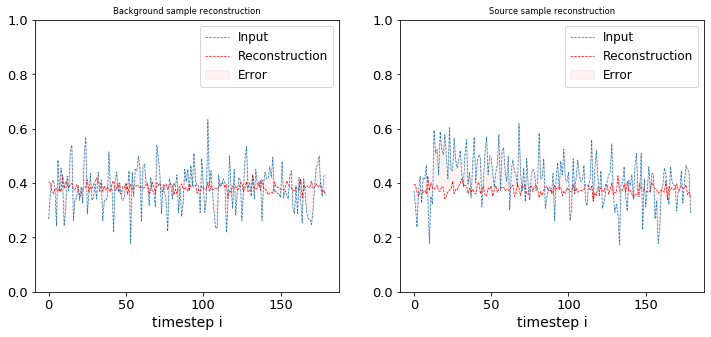

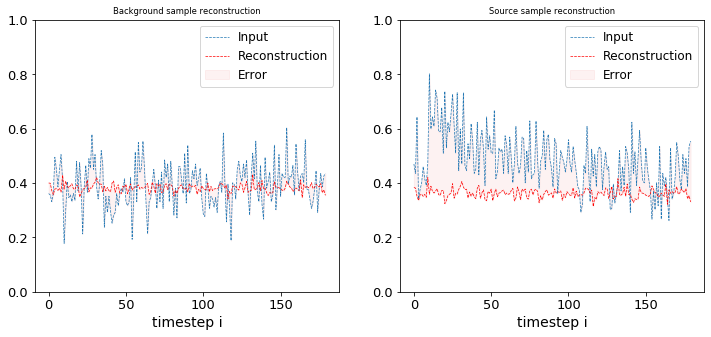

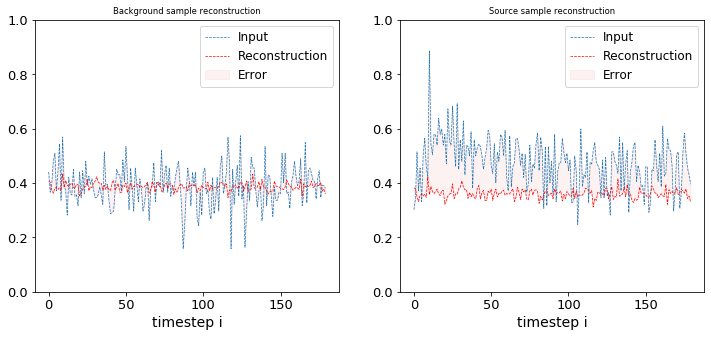

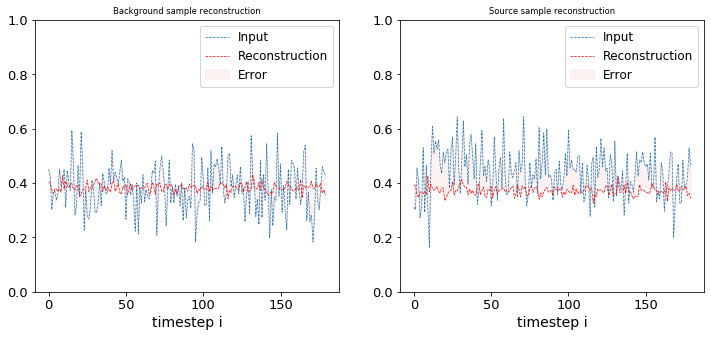

In [32]:
recoError(autoencoder)

# Anomaly detection method
Let's classify samples as anomalous if the reconstruction error is greater than one standard deviation from the normal training examples. 

### Reconsruction error for training and test set
The Autoencoder have learnt the background model and can reconstruct it (with some error..).
Let's see the error

In [137]:
def plotLoss(loss, labels, xlabel, threshold):

    fig, ax = plt.subplots(1,1,figsize=(10,5))
    add_matplotlib_params(ax)

    colors = ["blue","orange"]

    grbMSE = loss[labels]
    bkgMSE = loss[~labels]
    print(labels)
    print(len(loss))
    print(len(grbMSE))
    print(len(bkgMSE))
    
    ax.hist(bkgMSE, bins=25, label="Reconstruction MSE for a bkg sample", color="blue")
    ax.hist(grbMSE, bins=25, label="Reconstruction MSE for a src sample", color="red")

    ax.axvline(threshold, color="red", label="threshold")
    ax.set_xlabel(xlabel, fontsize=18)
    ax.set_ylabel("No of samples", fontsize=18)
    ax.grid()
    

    # ax.axvline(threshold, color="red", label="optimal threshold")
    ax.legend()


    plt.show()


tf.Tensor(
[0.06004263 0.06421731 0.07642857 0.13145365 0.05832362 0.06928053
 0.05501172 0.06524162 0.06595822 0.06483853 0.12584664 0.09053842
 0.08162844 0.09523018 0.101965   0.08402943 0.08110093 0.066012
 0.06851169 0.06370707 0.06856903 0.0996045  0.07408814 0.07942185
 0.07883814 0.109331   0.08124798 0.06156889 0.06738514 0.11281761
 0.09944765 0.08698659 0.07018334 0.05662745 0.09526389 0.07780538
 0.06496102 0.06535275 0.07641155 0.09791658 0.11132152 0.06475138
 0.06397412 0.12728824 0.12367414 0.07254106 0.06381062 0.07151163
 0.10519906 0.0907771  0.06762654 0.09751807 0.08319598 0.1385211
 0.06185199 0.09887607 0.07479628 0.06293568 0.07179063 0.06451733
 0.10037558 0.0656196  0.06950528 0.0669916  0.06545008 0.08335585
 0.0620562  0.06780427 0.10678487 0.09444483 0.10385732], shape=(71,), dtype=float32)
[False False  True  True False False False False False False  True  True
  True  True  True  True  True False False False False  True False  True
  True  True  True Fals

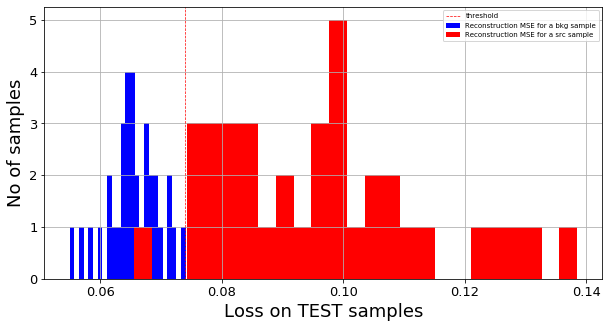

In [138]:
reconstructions = autoencoder.predict(test_data)
normal_sample_threshold = 0.074
loss = tf.keras.losses.mae(test_data, reconstructions)
print(loss)

plotLoss(loss, test_labels, "Loss on TEST samples", normal_sample_threshold)

Classify an sample as an grb if the reconstruction error is greater than the threshold.

In [135]:
def predict(model, data, threshold):
    reconstructions = model(data)
    loss = tf.keras.losses.mae(reconstructions, data)
    return tf.math.greater(loss, threshold)

def print_stats(predictions, labels):
    print("Accuracy = {}".format(accuracy_score(labels, preds)))
    print("Precision = {}".format(precision_score(labels, preds)))
    print("Recall = {}".format(recall_score(labels, preds)))

In [136]:
preds = predict(autoencoder, test_data, normal_sample_threshold)
print_stats(preds, test_labels)

Accuracy = 0.971830985915493
Precision = 0.972972972972973
Recall = 0.972972972972973
